<a href="https://colab.research.google.com/github/hammaduu/LLMs/blob/main/InvoiceBot_Pilot_Cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -qU langchain-groq langchain langchain_core "langchain-chroma>=0.1.2" langchain_community sentence_transformers fastembed faker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.4/438.4 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 87.8 MB/s eta 0:00:0

In [3]:
!pip install matplotlib

In [4]:
# Get API Key
import getpass, os
os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

Enter your Groq API key: ··········


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Import LLM
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama3-70b-8192", temperature=0, max_tokens=1024)

In [7]:
import pandas as pd
import random
import numpy as np
from datetime import datetime
from faker import Faker

fake = Faker()

# Generate 10 unique mock B2B customers
customers = [fake.company() for _ in range(10)]
months = ["2024-03", "2024-04"]

# Invoice summary (aggregated by customer per month)
invoice_summary_data = []
for customer in customers:
    for month in months:
        invoice_summary_data.append({
            "customer_name": customer,
            "invoice_month": month,
            "total_amount": random.randint(80000, 180000),
            "msisdn_count": random.randint(25, 75)
        })

invoice_summary_df = pd.DataFrame(invoice_summary_data)

# Generate ~50 MSISDNs with customer association
msisdns = []
for customer in customers:
    count = random.randint(5, 10)
    for _ in range(count):
        msisdns.append({
            "customer_name": customer,
            "msisdn": "9230" + ''.join([str(random.randint(0, 9)) for _ in range(7)])
        })

# Generate per-day MSISDN usage for March and April 2024
usage_data = []
months = ["2024-03", "2024-04"]
for record in msisdns:
    for month in months:
        for _ in range(random.randint(3, 7)):  # simulate multiple records per MSISDN
            day = random.randint(1, 28)
            usage_data.append({
                "msisdn": record["msisdn"],
                "customer_name": record["customer_name"],
                "date": f"{month}-{day:02}",
                "data_mb": random.randint(100, 5000),
                "calls": random.randint(0, 50),
                "sms": random.randint(0, 20),
                "location": fake.city()
            })

msisdn_usage_df = pd.DataFrame(usage_data)

# Preview samples
invoice_summary_df.head(), msisdn_usage_df.head()

(                    customer_name invoice_month  total_amount  msisdn_count
 0                   Weaver-Palmer       2024-03        118281            38
 1                   Weaver-Palmer       2024-04        125474            51
 2  Flores, Blankenship and Atkins       2024-03        143491            60
 3  Flores, Blankenship and Atkins       2024-04        119227            33
 4     Mccarthy, Jones and Andrews       2024-03         89217            75,
         msisdn  customer_name        date  data_mb  calls  sms      location
 0  92308055059  Weaver-Palmer  2024-03-28     3738     48   10     Sarahberg
 1  92308055059  Weaver-Palmer  2024-03-13     2721      1   20  East Michael
 2  92308055059  Weaver-Palmer  2024-03-12     3860     39   18  Rebeccashire
 3  92308055059  Weaver-Palmer  2024-03-14     3384     44   12      Cookstad
 4  92308055059  Weaver-Palmer  2024-04-16     2373     20   10   West Sheila)

In [8]:
# Tool Functions
def get_invoice_change(customer_name: str, month1: str, month2: str):
    customer_name = customer_name.lower().strip()
    month1 = month1.strip().strip("'\"")
    month2 = month2.strip().strip("'\"")

    # Invoice summary
    df = invoice_summary_df.copy()
    df["invoice_month"] = df["invoice_month"].astype(str).str.strip().str[:7]
    df["customer_name"] = df["customer_name"].astype(str).str.lower().str.strip()
    df_filtered = df[(df["customer_name"] == customer_name) & (df["invoice_month"].isin([month1, month2]))]

    if len(df_filtered) != 2:
        return f"Could not find data for both months: {month1}, {month2}"

    values = df_filtered.set_index("invoice_month")["total_amount"].to_dict()
    msisdn_counts = df_filtered.set_index("invoice_month")["msisdn_count"].to_dict()
    diff = values[month2] - values[month1]
    pct = round((diff / values[month1]) * 100, 2)

    base = f"{customer_name.title()}'s invoice changed from {values[month1]} in {month1} to {values[month2]} in {month2} — a change of {diff} ({pct}%)."

    # Usage data
    usage_df = msisdn_usage_df.copy()
    usage_df["customer_name"] = usage_df["customer_name"].str.lower().str.strip()
    usage_df["month"] = usage_df["date"].str[:7]

    usage_month1 = usage_df[(usage_df["customer_name"] == customer_name) & (usage_df["month"] == month1)]
    usage_month2 = usage_df[(usage_df["customer_name"] == customer_name) & (usage_df["month"] == month2)]

    if usage_month1.empty or usage_month2.empty:
        return base + " However, detailed usage data was unavailable to explain the reason."

    # Total usage comparisons
    def summarize(df):
        return {
            "data_mb": df["data_mb"].sum(),
            "calls": df["calls"].sum(),
            "sms": df["sms"].sum(),
            "avg_data_per_user": df.groupby("msisdn")["data_mb"].sum().mean()
        }

    sum1 = summarize(usage_month1)
    sum2 = summarize(usage_month2)

    reasons = []

    if msisdn_counts[month2] > msisdn_counts[month1]:
        reasons.append(f"increased MSISDN count from {msisdn_counts[month1]} to {msisdn_counts[month2]}")
    elif msisdn_counts[month2] < msisdn_counts[month1]:
        reasons.append(f"reduced MSISDN count from {msisdn_counts[month1]} to {msisdn_counts[month2]}")

    if sum2["data_mb"] > sum1["data_mb"]:
        reasons.append(f"increased total data usage ({sum1['data_mb']}MB → {sum2['data_mb']}MB)")
    elif sum2["data_mb"] < sum1["data_mb"]:
        reasons.append(f"reduced total data usage ({sum1['data_mb']}MB → {sum2['data_mb']}MB)")

    if sum2["calls"] > sum1["calls"]:
        reasons.append(f"increased total call volume ({sum1['calls']} → {sum2['calls']})")
    elif sum2["calls"] < sum1["calls"]:
        reasons.append(f"reduced total call volume ({sum1['calls']} → {sum2['calls']})")

    if sum2["sms"] > sum1["sms"]:
        reasons.append(f"increased total SMS ({sum1['sms']} → {sum2['sms']})")
    elif sum2["sms"] < sum1["sms"]:
        reasons.append(f"reduced total SMS ({sum1['sms']} → {sum2['sms']})")

    if sum2["avg_data_per_user"] > sum1["avg_data_per_user"]:
        reasons.append("higher average data usage per MSISDN")
    elif sum2["avg_data_per_user"] < sum1["avg_data_per_user"]:
        reasons.append("lower average data usage per MSISDN")

    reason_text = "Reason: " + "; ".join(reasons).capitalize() + "."

    # Top MSISDNs
    top_msisdns = usage_month2.groupby("msisdn")["data_mb"].sum().sort_values(ascending=False).head(5)
    msisdn_text = "\nTop 5 MSISDNs (by data usage in " + month2 + "):\n" + top_msisdns.reset_index().to_string(index=False)

    # Show charts
    plot_invoice_charts(customer_name, month1, month2, usage_month1, usage_month2)

    return base + "\n" + reason_text + "\n" + msisdn_text

def get_top_msisdns_by_data(customer_name: str, month: str, top_n: int = 5):
    customer_name = customer_name.lower().strip()
    df = msisdn_usage_df.copy()
    df["customer_name"] = df["customer_name"].str.lower().str.strip()
    df["month"] = df["date"].str[:7] if df["date"].dtype == "O" else df["date"].dt.strftime("%Y-%m")
    msisdn_df = df[(df["customer_name"] == customer_name) & (df["month"] == month)]
    if msisdn_df.empty:
        return f"No usage data found for '{customer_name.title()}' in {month}."
    totals = msisdn_df.groupby("msisdn")["data_mb"].sum().sort_values(ascending=False).head(top_n)
    return f"Top {top_n} MSISDNs by data usage for {customer_name.title()} in {month}:\n" + totals.reset_index().to_string(index=False)

In [9]:
import matplotlib.pyplot as plt

def plot_invoice_charts(customer_name, month1, month2, usage_month1, usage_month2):
    """Displays comparison charts for usage types and top MSISDNs."""

    def summarize(df):
        return {
            "data_mb": df["data_mb"].sum(),
            "calls": df["calls"].sum(),
            "sms": df["sms"].sum()
        }

    sum1 = summarize(usage_month1)
    sum2 = summarize(usage_month2)

    # --- Usage Comparison Chart ---
    usage_comparison_df = pd.DataFrame({
        "Metric": ["Data MB", "Calls", "SMS"],
        month1: [sum1["data_mb"], sum1["calls"], sum1["sms"]],
        month2: [sum2["data_mb"], sum2["calls"], sum2["sms"]],
    })

    usage_comparison_df.set_index("Metric").plot.bar()
    plt.title(f"Usage Comparison for {customer_name.title()} ({month1} vs {month2})")
    plt.ylabel("Total")
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Top MSISDNs in Month2 ---
    top_msisdns = usage_month2.groupby("msisdn")["data_mb"].sum().sort_values(ascending=False).head(5)
    if not top_msisdns.empty:
        top_msisdns.plot(kind="bar", color="skyblue")
        plt.title(f"Top 5 MSISDNs by Data Usage in {month2}")
        plt.ylabel("Total Data MB")
        plt.xlabel("MSISDN")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [10]:
# Wrappers
from langchain.tools import Tool

def safe_invoice_change_wrapper(input_str: str):
    try:
        parts = input_str.split(",", 2)
        if len(parts) < 3:
            return "[Tool Error - GetInvoiceChange] Invalid input. Expected format: Customer, YYYY-MM, YYYY-MM"
        customer = parts[0].strip(" '\"\n").strip()
        month1 = parts[1].strip(" '\"\n").strip()
        month2 = parts[2].split()[0].strip(" '\"\n").strip()
        return get_invoice_change(customer, month1, month2)
    except Exception as e:
        return f"[Tool Error - GetInvoiceChange] {str(e)}"

def safe_top_msisdns_wrapper(input_str: str):
    try:
        parts = [x.strip().strip("'").strip('"') for x in input_str.split(",")]
        customer = parts[0]
        month = parts[1]
        return get_top_msisdns_by_data(customer, month)
    except Exception as e:
        return f"[Tool Error - GetTopMSISDNs] {str(e)}"

# Tool registry
tools = [
    Tool(
        name="GetInvoiceChange",
        func=safe_invoice_change_wrapper,
        description="Compare invoice totals between two months. Input: 'Customer Name,YYYY-MM,YYYY-MM'",
        return_direct=True
    ),
    Tool(
        name="GetTopMSISDNs",
        func=safe_top_msisdns_wrapper,
        description="Get top MSISDNs by data usage. Input: 'Customer Name,YYYY-MM'",
        return_direct=True
    )
]

In [11]:
# Prompt template wiring
from langchain.prompts import PromptTemplate
from langchain.agents import initialize_agent, AgentType

prompt = PromptTemplate(
    input_variables=["input"],
    template="""
You are a telecom invoice analyst. Given a customer name and two months, reason about invoice change.
Use tool `GetInvoiceChange` to compare invoices, then `GetTopMSISDNs` to explore usage.

Question: {input}
"""
)

agent_executor = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    agent_kwargs={"prefix": prompt.template},
    verbose=False
)

<ipython-input-11-6187f226fba6>:15: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent_executor = initialize_agent(


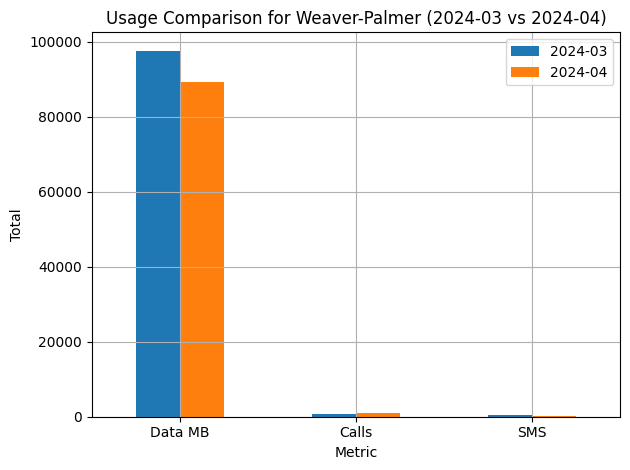

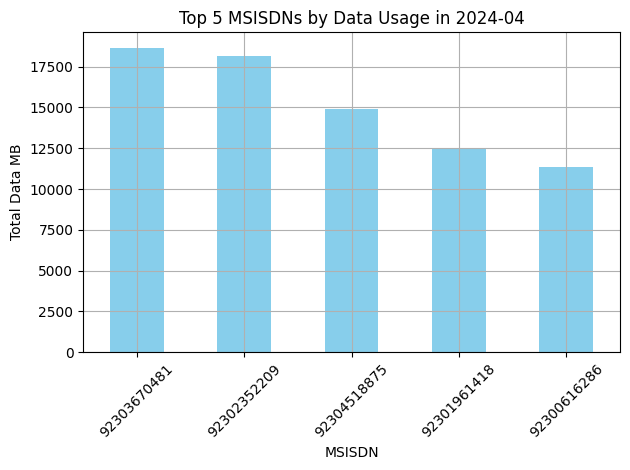

Weaver-Palmer's invoice changed from 118281 in 2024-03 to 125474 in 2024-04 — a change of 7193 (6.08%).
Reason: Increased msisdn count from 38 to 51; reduced total data usage (97605mb → 89339mb); increased total call volume (790 → 1068); reduced total sms (362 → 308); lower average data usage per msisdn.

Top 5 MSISDNs (by data usage in 2024-04):
     msisdn  data_mb
92303670481    18673
92302352209    18145
92304518875    14912
92301961418    12450
92300616286    11348


In [14]:
# Sample runs
response = agent_executor.run("Why did invoice increase for Weaver-Palmer between 2024-03 and 2024-04?")
print(response)

In [16]:
agent_executor.run("List top 5 MSISDNs by data usage for Weaver-Palmer in 2024-03.")

'Top 5 MSISDNs by data usage for Weaver-Palmer in 2024-03:\n     msisdn  data_mb\n92304518875    21237\n92303670481    18050\n92300878619    14760\n92308055059    13703\n92302352209    12142'

In [18]:
msisdn_usage_df[
    (msisdn_usage_df["customer_name"].str.lower().str.strip() == "weaver-palmer") &
    (msisdn_usage_df["date"].str.startswith("2024-03"))
]

,msisdn,customer_name,date,data_mb,calls,sms,location
0,92308055059,Weaver-Palmer,2024-03-28,3738,48,10,Sarahberg
1,92308055059,Weaver-Palmer,2024-03-13,2721,1,20,East Michael
2,92308055059,Weaver-Palmer,2024-03-12,3860,39,18,Rebeccashire
3,92308055059,Weaver-Palmer,2024-03-14,3384,44,12,Cookstad
7,92300616286,Weaver-Palmer,2024-03-09,2923,0,14,Shannonberg
8,92300616286,Weaver-Palmer,2024-03-15,2563,12,4,Rasmussenmouth
9,92300616286,Weaver-Palmer,2024-03-20,294,42,14,New Herbert
13,92301961418,Weaver-Palmer,2024-03-12,2538,3,20,Wrightburgh
14,92301961418,Weaver-Palmer,2024-03-06,330,21,10,Port Marymouth
15,92301961418,Weaver-Palmer,2024-03-22,2600,15,2,Martinezside


In [21]:
def run_chat():
    print("📞 Telecom Invoice Chatbot Ready (type 'exit' to quit)\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            print("Bot: Goodbye!")
            break
        try:
            response = agent_executor.run(user_input)
            print("Bot:", response)
        except Exception as e:
            print("Bot [error]:", str(e))

📞 Telecom Invoice Chatbot Ready (type 'exit' to quit)

You: List top 5 MSISDNs by data usage for Weaver-Palmer in 2024-03.
Bot: Top 5 MSISDNs by data usage for Weaver-Palmer in 2024-03:
     msisdn  data_mb
92304518875    21237
92303670481    18050
92300878619    14760
92308055059    13703
92302352209    12142
You: Why did invoice increase for Weaver-Palmer between 2024-03 and 2024-04?


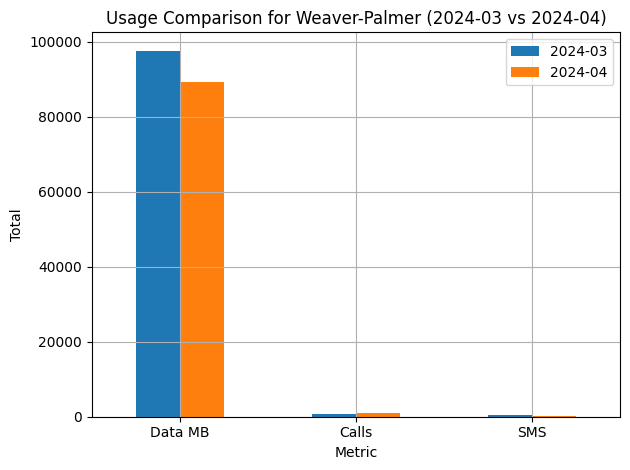

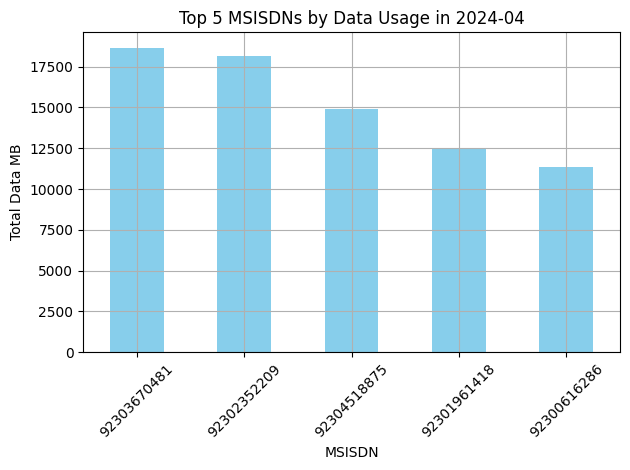

Bot: Weaver-Palmer's invoice changed from 118281 in 2024-03 to 125474 in 2024-04 — a change of 7193 (6.08%).
Reason: Increased msisdn count from 38 to 51; reduced total data usage (97605mb → 89339mb); increased total call volume (790 → 1068); reduced total sms (362 → 308); lower average data usage per msisdn.

Top 5 MSISDNs (by data usage in 2024-04):
     msisdn  data_mb
92303670481    18673
92302352209    18145
92304518875    14912
92301961418    12450
92300616286    11348
You: exit
Bot: Goodbye!


In [24]:
run_chat()